## Introduction
This exercise is just to practice using partial least squares regression (PLSR) on some random data.

In [1]:
import math
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression

%matplotlib inline
sns.set_style('white')

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# importing raw data from excel into a pandas dataframe
df_raw = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

# display raw file
df_raw.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


## Clean the data
Clean the data with just columns we want (drop columns with NaN values).

In [3]:
# setting the proper heading from the 4th row of raw data
headers = df_raw.iloc[3]

# exclude rows 1 through 4 (or rows 0, 1, 2, 3)
df_ny = pd.DataFrame(df_raw.values[4:], columns=headers)

# renaming columns
df_ny.columns = ['city', 'pop', 'vc', 'murder', 'rape1', 'rape2', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3']

# dropping columns with NaN values
df_ny = df_ny.drop(['rape1', 'arson3'], axis=1)

# removing last 3 rows of instructional data
df_ny = df_ny.drop([348, 349, 350], axis=0)
df_ny.head()

,city,pop,vc,murder,rape2,robbery,aa,pc,burglary,lt,mvt
0,Adams Village,1861,0,0,0,0,0,12,2,10,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1
2,Akron Village,2846,3,0,0,0,3,16,1,15,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142
4,Albion Village,6388,23,0,3,4,16,223,53,165,5


Convert columns to float.

In [4]:
#converting string values to float and creating 'pop2' column which is pop squared

df_ny["pop"] = [np.float(x) for x in df_ny["pop"]]
df_ny["vc"] = [np.float(x) for x in df_ny["vc"]]
df_ny["murder"] = [np.float(x) for x in df_ny["murder"]]
df_ny["rape2"] = [np.float(x) for x in df_ny["rape2"]]
df_ny["robbery"] = [np.float(x) for x in df_ny["robbery"]]
df_ny["aa"] = [np.float(x) for x in df_ny["aa"]]
df_ny["pc"] = [np.float(x) for x in df_ny["pc"]]
df_ny["burglary"] = [np.float(x) for x in df_ny["burglary"]]
df_ny["lt"] = [np.float(x) for x in df_ny["lt"]]
df_ny["mvt"] = [np.float(x) for x in df_ny["mvt"]]


In [5]:
df_ny.isnull().sum()

city        0
pop         0
vc          0
murder      0
rape2       0
robbery     0
aa          0
pc          0
burglary    0
lt          0
mvt         0
dtype: int64

In [6]:
df_ny.head()

,city,pop,vc,murder,rape2,robbery,aa,pc,burglary,lt,mvt
0,Adams Village,1861.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,10.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,0.0,0.0,3.0,24.0,3.0,20.0,1.0
2,Akron Village,2846.0,3.0,0.0,0.0,0.0,3.0,16.0,1.0,15.0,0.0
3,Albany,97956.0,791.0,8.0,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0
4,Albion Village,6388.0,23.0,0.0,3.0,4.0,16.0,223.0,53.0,165.0,5.0


Find NYC data, so we can drop this outlier which was discovered in previous exercises.

In [7]:
print(min(df_ny['pop']))
print(max(df_ny['pc']))
print(df_ny.loc[df_ny['city'] == 'New York'])
print('\n')
print(df_ny.loc[df_ny['pop'] == 526.0])

526.0
141971.0
         city        pop       vc  murder   rape2  robbery       aa        pc  \
216  New York  8396126.0  52384.0   335.0  1112.0  19170.0  31767.0  141971.0   

     burglary        lt     mvt  
216   16606.0  117931.0  7434.0  


                  city    pop   vc  murder  rape2  robbery   aa   pc  \
118  Glen Park Village  526.0  0.0     0.0    0.0      0.0  0.0  5.0   

     burglary   lt  mvt  
118       0.0  5.0  0.0  


Text(0, 0.5, 'Number of pc instances')

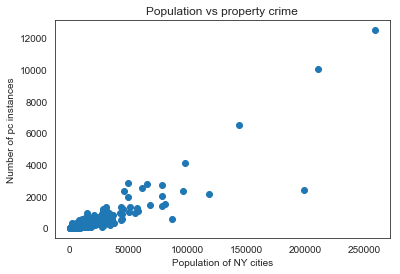

In [8]:
# drop nyc data
df_ny = df_ny.drop([216])

# produce new scatterplot
plt.scatter(df_ny['pop'], df_ny['pc'])
plt.title('Population vs property crime')
plt.xlabel('Population of NY cities')
plt.ylabel('Number of pc instances')

The scatterplot above shows the population (x-axis) of NY cities comared to the property crime (y-axis).

## Build model
First, with 9 features.

In [9]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_ny['pc']
X = df_ny[['pop', 'vc', 'murder', 'rape2', 'robbery', 'aa', 'burglary', 'lt', 'mvt']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-1.44444145e-17  1.50990331e-14  8.39502079e-14 -4.29361408e-14
 -1.65700786e-14 -9.52016244e-15  1.00000000e+00  1.00000000e+00
  1.00000000e+00]

Intercept: 
 3.410605131648481e-13

R-squared:
1.0


Now, let's build a model using PLSR and just 3 features.

R-squared regression: 1.0
R-squared PLSR: 0.9981628740516195


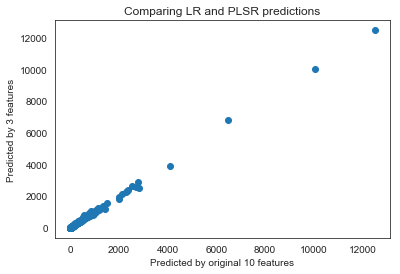

In [10]:
# Save predicted values.
Y_pred = regr.predict(X)
print('R-squared regression:', regr.score(X, Y))

# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=3)

# # Reduce X to R(X) and regress on y.
pls1.fit(X, Y)

# Save predicted values.
Y_PLS_pred = pls1.predict(X)
print('R-squared PLSR:', pls1.score(X, Y))

# Compare the predictions of the two models
plt.scatter(Y_pred,Y_PLS_pred) 
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 3 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

Looks great.  We have a R-squared value of .998 for 3 features vs. 1.0 for 9 features.

Let's do it again with just 2 features.

R-squared regression: 1.0
R-squared PLSR: 0.986097445410595


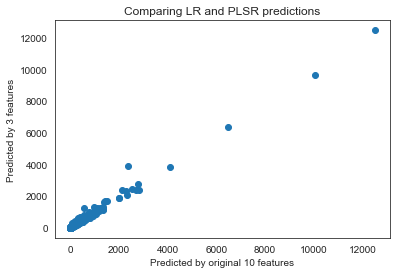

In [11]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_ny['pc']
X = df_ny[['pop', 'vc', 'murder', 'rape2', 'robbery', 'aa', 'burglary', 'lt', 'mvt']]
regr.fit(X, Y)

# Save predicted values.
Y_pred = regr.predict(X)
print('R-squared regression:', regr.score(X, Y))

# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=2)

# # Reduce X to R(X) and regress on y.
pls1.fit(X, Y)

# Save predicted values.
Y_PLS_pred = pls1.predict(X)
print('R-squared PLSR:', pls1.score(X, Y))

# Compare the predictions of the two models
plt.scatter(Y_pred,Y_PLS_pred) 
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 3 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

Still looks really good.  We have a R-squared value of .986 with just 2 features.

## Conclusion and discussion
Using all 9 features we have a R-squared value of **1.0**.  However, reducing the number of features to 3 and to 2, we have R-squared values of **.998** and **.986** respectively.

Having significantly less features can greatly reduce the complexity of a model and significantly increase the solve time and training time to run the model.  We have shown that reducing the number of features in this case from 9 to 3 and to 2 still build a very robust model with high predictive value (for this particular training data).